# An example of coherent state quantum process tomography
- First we create number of coherent states with different phase and amplitude and save their density matrices in folder rho-in
- We apply quantum operation to the generated coherent state
- The density matrix after the quantum operation is used for generating quadratures

In [32]:
import sys
import numpy as np
import os  
# Insert the path of modules folder 
sys.path.insert(0, "src/")
import barplot as bp
import quantum_process as qp
import quantum_states as qs
import barplot as bp
import gen_quad_sample


# Create a folder for the data
data_folder = 'Data-src'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
elif not os.path.exists(data_folder):
    os.makedirs(data_folder)

# range of coherent states' amplitudes
amplitudes = np.linspace(0.1, 2.6, 12)
# range of phases
phases = np.linspace(0, 2*np.pi, 6)

# Hilbert space dimensions
h_dim = 4

# Use a linear attenuator as a quantum process
attenuator = qp.QAttenuation(Hdims = h_dim, eta = 0.4)
# For each input desnity matrix 8 quadratures are measured
quads_to_measure = np.linspace(0, np.pi, 8)
# For each quadratures ns points are sampled
ns = 1000
# number of cpu's cores for parrallel execution
n_cpu = 8


for alpha in amplitudes:
    for phi in phases:
        cs = qs.CoherentState(alpha=alpha,phi=phi,N=h_dim)
        rho_in = cs.get_rho()
        # apply process tensor on input density matrix rho_in
        rho_out = attenuator.operation(rho_in)
        # generate quadrature samples from density matrix rho_out
        gen_quad_sample.parrallel_gen_quad(rho = rho_out, quads=quads_to_measure, size_cpu=n_cpu, path=f'{data_folder}/cs-a-{alpha:.2f}-phi-{phi:.2f}/', ns=ns, xmin=-4, xmax=4)
        np.save(f'{data_folder}/cs-a-{alpha:.2f}-phi-{phi:.2f}/rho', rho_in)

# Quantum process tomography (QST)
- The generated data can is used for QST
- We run quantum process tomography script that reconstruct the process tensor based on the provided data of input coherent states and measured quadratures
- The options for algorithm are:
1. Path to the folders with data
2. Hilbert space's dimension
3. The phase invarance conjecture 
4. Number of iteration 
5. Number of CPU cores

In [1]:
! python src/csqpt.py -path Data-src -hdim 4 -pi false -it 20 -cpu 8

Directories to check:
 ['Data-src/cs-a-1.92-phi-1.26', 'Data-src/cs-a-1.69-phi-5.03', 'Data-src/cs-a-2.60-phi-0.00', 'Data-src/cs-a-1.24-phi-3.77', 'Data-src/cs-a-1.01-phi-0.00', 'Data-src/cs-a-1.24-phi-5.03', 'Data-src/cs-a-2.37-phi-3.77', 'Data-src/cs-a-0.10-phi-5.03', 'Data-src/cs-a-0.55-phi-2.51', 'Data-src/cs-a-1.01-phi-5.03', 'Data-src/cs-a-1.46-phi-1.26', 'Data-src/cs-a-1.69-phi-0.00', 'Data-src/cs-a-2.60-phi-2.51', 'Data-src/cs-a-1.92-phi-2.51', 'Data-src/cs-a-2.37-phi-2.51', 'Data-src/cs-a-1.46-phi-3.77', 'Data-src/cs-a-2.15-phi-0.00', 'Data-src/cs-a-1.92-phi-0.00', 'Data-src/cs-a-2.37-phi-6.28', 'Data-src/cs-a-2.15-phi-1.26', 'Data-src/cs-a-1.46-phi-6.28', 'Data-src/cs-a-1.24-phi-1.26', 'Data-src/cs-a-1.69-phi-1.26', 'Data-src/cs-a-1.46-phi-0.00', 'Data-src/cs-a-1.24-phi-0.00', 'Data-src/cs-a-0.33-phi-3.77', 'Data-src/cs-a-2.60-phi-1.26', 'Data-src/cs-a-0.10-phi-6.28', 'Data-src/cs-a-2.37-phi-1.26', 'Data-src/cs-a-1.01-phi-6.28', 'Data-src/cs-a-0.78-phi-6.28', 'Data-src/cs-a-

# Plot the diagonal part of reconstructed process tensor

/home/cloud-user/pmp/lib/python3.7/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


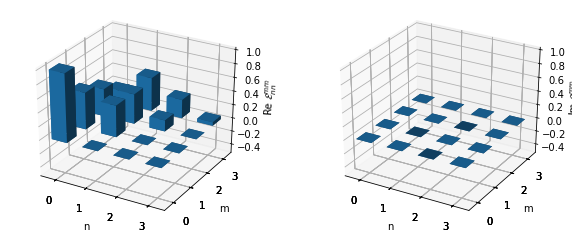

In [2]:
import numpy as np
import sys
# Insert the path of modules folder 
sys.path.insert(0, "src/")
import barplot as bp
import quantum_process as qp

def proj(m:int, Hdims:int) -> np.array:
    X = np.zeros((Hdims,Hdims))
    X[m,m] = 1 
    return X

def diag_elem(X:np.array, m:int, n:int, Hdims) -> float:
    diag_projector = np.kron(proj(m,Hdims),proj(n,Hdims)) 
    Xp = np.dot(diag_projector,np.dot(X, diag_projector))
    return (Xp[Xp!=0][0])


def get_diag_tensor(X:np.array) -> np.array:
    if not X.shape[0] == X.shape[1]:
        raise ValueError('The tensor is not quadratic')
        
    Hdims = int(np.sqrt(X.shape[0]))
    tensor = np.zeros((Hdims,Hdims))
    for i in np.arange(0,Hdims):
        for k in np.arange(0,Hdims):
            tensor[i,k] = (diag_elem(X=X,m=i,n=k,Hdims=Hdims)) # np.real
    return tensor       

x = np.load('reconstructed-process-tensor.npy')
diag_process_tensor = get_diag_tensor(x)




bp.bar_plot(rho = diag_process_tensor, name=f'reconstructed-process-tensor', plot_img_part = True, label = "$\\mathcal{E}^{mm}_{nn}$")

# Original process tensor
For comparision we may present the original tensor

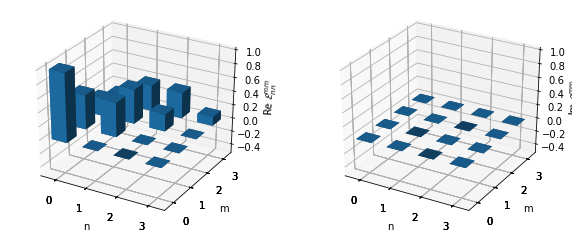

In [28]:
attenuator = qp.QAttenuation(Hdims = 4, eta = 0.5)
diag_theory = attenuator.get_diag_tensor()
bp.bar_plot(rho = diag_theory, name=f'theoretical-process-tensor', plot_img_part = True, label = "$\\mathcal{E}^{mm}_{nn}$")